6/11/18

In this notebook I attempt to apply block centroid allocation to convert data aggregated by DOGAMI Neighborhood Unit to the larger neighborhoods defined by the Disaster Resilience Team. I leverage DB data wrangling functions written by Fred Pearce (https://github.com/hackoregon/disaster-resilience/blob/analytics/notebooks/block_centroid_allocation_dogami_to_disaster.ipynb) to access the DOGAMI data and then use geopandas for spatial operations.

In [1]:
# Jupyter notebook for analyzing DOGAMI data, see Scott Tse's emergence-response notebook at
# https://github.com/hackoregon/emergency-response/blob/analytics/notebooks/census_eda_geo.ipynb
# See block centroid allocation method described here: 
# https://github.com/hackoregon/disaster-resilience/blob/analytics/notebooks/block_centroid_allocation.ipynb
# NOTE: Don't need all of these!
# Import modules included in "kitchen-sink"
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import gdal
from osgeo import osr, ogr
import pandas as pd
import psycopg2
from pyproj import Geod
import seaborn as sns
from shapely.geometry import Polygon
import sys
# Import modules NOT included in "kitchen-sink", not sure about osgeo...
from dotenv import load_dotenv, find_dotenv # install python-dotenv
import geoplot as gplt   # requires cython
import geoplot.crs as gcrs
%matplotlib inline

In [2]:
# Define ALL parameters in dictionary (convert to json config file!)
params = {
    'geometry_in': {
        'from_postgis': {
            # You MUST have a .env file specifying parameters for postgis db in order to
            # read data in from postgis! See sample_env.txt at 
            # https://github.com/hackoregon/disaster-resilience/blob/analytics/notebooks
            'query': {
                'string': '''
                    SELECT nu.nuid,
                        nu.county AS county,
                        nu.acres AS acres,
                        nu.bldgcount AS buildingcount,
                        nu.bldgsqft AS buildingsquarefeet,
                        nu.bldgcost AS buildingcost,
                        nu.bldgweight AS buildingweight,
                        nu.contentcost AS contentcost,
                        nu.permresidents AS permanentresidents,
                        nu.dayoccupants AS dayoccupants,
                        nu.nightoccupants AS nightoccupants,
                        ST_TRANSFORM(nu.wkb_geometry, 4326) AS geometry,
                        lnuw.bldgloss AS buildingloss_wet, 
                        lnuw.contentloss AS contentloss_wet,
                        lnuw.debris AS debris_wet,
                        lnuw.displacedpop AS displacedpopulation_wet,
                        lnuw.pdsnone AS buildings_nodamage_wet,
                        lnuw.pdsslight AS buildings_slightdamage_wet,
                        lnuw.pdsmoderate AS buildings_moderatedamage_wet,
                        lnuw.pdsextensive AS buildings_extensivedamage_wet,
                        lnuw.pdscomplete AS buildings_completedamage_wet,
                        lnuw.casdaytotal AS casualtiestotal_day_wet,
                        lnuw.casdayl1 AS casualtieslevel1_day_wet,
                        lnuw.casdayl2 AS casualtieslevel2_day_wet,
                        lnuw.casdayl3 AS casualtieslevel3_day_wet,
                        lnuw.casdayl4 AS casualtieslevel4_day_wet,
                        lnuw.casnighttotal AS casualtiestotal_night_wet,
                        lnuw.casnightl1 AS casualtieslevel1_night_wet,
                        lnuw.casnightl2 AS casualtieslevel2_night_wet,
                        lnuw.casnightl3 AS casualtieslevel3_night_wet,
                        lnuw.casnightl4 AS casualtieslevel4_night_wet,
                        lnud.bldgloss AS buildingloss_dry, 
                        lnud.contentloss AS contentloss_dry,
                        lnud.debris AS debris_dry,
                        lnud.displacedpop AS displacedpopulation_dry,
                        lnud.pdsnone AS buildings_nodamage_dry,
                        lnud.pdsslight AS buildings_slightdamage_dry,
                        lnud.pdsmoderate AS buildings_moderatedamage_dry,
                        lnud.pdsextensive AS buildings_extensivedamage_dry,
                        lnud.pdscomplete AS buildings_completedamage_dry,
                        lnud.casdaytotal AS casualtiestotal_day_dry,
                        lnud.casdayl1 AS casualtieslevel1_day_dry,
                        lnud.casdayl2 AS casualtieslevel2_day_dry,
                        lnud.casdayl3 AS casualtieslevel3_day_dry,
                        lnud.casdayl4 AS casualtieslevel4_day_dry,
                        lnud.casnighttotal AS casualtiestotal_night_dry,
                        lnud.casnightl1 AS casualtieslevel1_night_dry,
                        lnud.casnightl2 AS casualtieslevel2_night_dry,
                        lnud.casnightl3 AS casualtieslevel3_night_dry,
                        lnud.casnightl4 AS casualtieslevel4_night_dry
                    FROM neighborhood_units nu
                    INNER JOIN loss_neighborhood_unit_csz_m9p0_dry lnud
                    ON nu.nuid = lnud.nuid
                    INNER JOIN loss_neighborhood_unit_csz_m9p0_wet lnuw
                    ON nu.nuid = lnuw.nuid
                    ''',
                'epsg_code': 4326
                #'table_name': ['neighborhood_units', 'loss_neighborhood_unit_csz_m9p0_dry',
                #              'loss_neighborhood_unit_csz_m9p0_wet'],
                #'select_cols': 'nuid',
                #'geometry_col': 'wkb_geometry',
                #'epsg_code': 4326
            }
        }
    },
    'geometry_out': {
        'from_file': {
            'name':'./Data/DisasterNeighborhoods_FIXED_final/RLIS_ST_clips_pdx_jurisa_FIXED.dbf',
            'geom_col': 'geometry'
        },
    },
    'write_csv': {
        'name': "./bca_test_results.csv"
        #'name': "./DOGAMI_neighborhoodunits_raster_stats_v3.csv"
    }
}

In [6]:
print(params['geometry_in']['from_postgis']['query']['epsg_code'])   

4326


In [3]:
# Functions for obtaining geopandas dataframe containing geometry column from either
# 1) a local file (e.g. .dba file) or 2) interacting with PostGres database
def pgconnect():
    """Establish connection to PostGres database using the parameters specified in .env file.
    First, walk root diretory to find and load .env file w/ PostGres variables defining database, 
    user, host, password, and port variables.
    Then, return connection to database from psycopg2.connect
    """
    try:
        load_dotenv(find_dotenv())
        conn = psycopg2.connect(database=os.environ.get("PG_DATABASE"), user=os.environ.get("PG_USER"), 
                            password = os.environ.get("PG_PASSWORD"), 
                            host=os.environ.get("PG_HOST"), port=os.environ.get("PG_PORT"))
        print("Opened database successfully\n")
        return conn
    except psycopg2.Error as e:
        print("Unable to connect to the database\n")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        #print(traceback.format_exc())
        return None

def get_query_string(table_name, select_cols, geometry_col, epsg_code):
    """Build query string from parameter inputs defining table name, all the columns
    to select, select_cols, the column that defines the geometry, geometry_col, and
    the epsg code that defines the ellipsoid.
    """
    query_string = 'SELECT ' + select_cols + ', ' + \
            'ST_TRANSFORM({}, {}) AS geometry'.format(geometry_col, epsg_code)
    return query_string + ' FROM {}'.format(table_name)
    
    
def get_geometry_from_postgis(postgis_params):
    '''
    This function takes a dictionary containing parameters for building a SQL query,
    as defined in get_query_string, then connects to a postgis db, selects the 
    data specified in the query, and finally returns a geodataframe with a single
    column named geometry that contains shape data.
    '''
    #query_string = get_query_string(**postgis_params['query'])
    query_string = postgis_params['query']['string']
    conn = pgconnect()
    #cur = conn.cursor()
    print("SQL QUERY = "+query_string+'\r\n')
    try:
        geo_df = gpd.GeoDataFrame.from_postgis(
            query_string, 
            conn, 
            geom_col='geometry', 
            crs={'init': u'epsg:{}'.format(postgis_params['query']['epsg_code'])}, 
            coerce_float=False
        )
        return geo_df
    except Exception as e:
        print(e)
    finally:
        conn.close()
        
def get_geometry_from_file(name, geom_col='geometry'):
    """Import geometry from a file using geopandas.read_file
    Returns only the geometry column!
    """
    gdf = gpd.read_file(name)
    #print(type(gdf))
    return gdf

def calc_square_lonlat(lon_lat, xy_offset):
    """Calculate the longitude and latitude corresponding to the upper-right and lower-left
    corners of a square box centered on lat_lon, with a width of 2*xy_offset. 
    xy_offset MUST be in meters. Uses WGS84 (epsg=4326) ellipsoid.
    """
    az = [45, 225]
    lon = 2*[lon_lat[0]]
    lat = 2*[lon_lat[1]]
    mag = 2*[np.sqrt(2)*xy_offset]
    g = Geod(ellps='WGS84')
    rl_lon, tb_lat, _ = g.fwd(lon, lat, az, mag)
    return (rl_lon, tb_lat)

def calc_square_polygon(lon_lat, xy_offset):
    """Calculate polygon defining square box centered on lon, lat (decimal degrees)
    with a width of 2*xy_offset (meters).
    """
    rl_lon, tb_lat = calc_square_lonlat(lon_lat, xy_offset)
    poly = [Polygon((
            (rl_lon[0], tb_lat[0]),
            (rl_lon[0], tb_lat[1]),
            (rl_lon[1], tb_lat[1]),
            (rl_lon[1], tb_lat[0])
    ))]
    return poly

def get_geometry_from_point(lon_lat, xy_offset, xy_units="m"):
    """Returns a geodataframe containing a single geometry column that
    defines a square box centered on a point, specified as a lat, lon pair,
    The input parameter xy_offset defines the box half-width 
    1) Calculate the top-right corner and bottom-left corner of square box
    centered on lon_lat, using the WGS84 ellipsoid.
    2) Use the lon, lat of each corner to build a rectangular 
    polygon using shapely Polygon.
    3) Convert polygon to pandas geodataframe, set coordinate reference to 
    epsg 4326 (equivalent to WGS84).
    """
    if xy_units == "m":
        poly = calc_square_polygon(lon_lat, xy_offset)
        # Build geodataframe with one row, column
        gdf = gpd.GeoDataFrame(poly, columns=['geometry'], geometry='geometry')
        gdf.crs = {'init' :'epsg:4326'}
        return gdf
    else:
        print("Error: input xy_offset MUST be in meters!!!")

def get_geodf_geometry(**kwargs):
    """Import geometry either from point and size, a file, or from postgis db
    """
    if 'from_point' in kwargs:
        return get_geometry_from_point(**kwargs['from_point'])
    elif 'from_file' in kwargs:
        return get_geometry_from_file(**kwargs['from_file'])
    elif 'from_postgis' in kwargs:
        return get_geometry_from_postgis(kwargs['from_postgis'])

In [8]:
# Step 1) Select geodataframe from Postgis db. Make sure geometry
# has a valid epsg Spatial reference assigned to it, such as 4326 (lon/lat)
# For a Postgis-derived geometry, this is done on the db-side using ST_TRANSFORM
loss_gdf = get_geodf_geometry(**params['geometry_in'])
loss_gdf.info()
print(loss_gdf.geometry.crs)
print(loss_gdf.geometry)
loss_gdf_orig = loss_gdf.copy()

Opened database successfully

SQL QUERY = 
                    SELECT nu.nuid,
                        nu.county AS county,
                        nu.acres AS acres,
                        nu.bldgcount AS buildingcount,
                        nu.bldgsqft AS buildingsquarefeet,
                        nu.bldgcost AS buildingcost,
                        nu.bldgweight AS buildingweight,
                        nu.contentcost AS contentcost,
                        nu.permresidents AS permanentresidents,
                        nu.dayoccupants AS dayoccupants,
                        nu.nightoccupants AS nightoccupants,
                        ST_TRANSFORM(nu.wkb_geometry, 4326) AS geometry,
                        lnuw.bldgloss AS buildingloss_wet, 
                        lnuw.contentloss AS contentloss_wet,
                        lnuw.debris AS debris_wet,
                        lnuw.displacedpop AS displacedpopulation_wet,
                        lnuw.pdsnone AS buildings_nodamag

In [9]:
# Modify loss_gdf from dogami to 1) drop ratio values as they don't make sense to include
# given the way we're aggregating to disaster neighborhoods (changed sql query to address this), 
# 2) rename casualtieslevel4 column labels to fatalitiestotal, and 
# 3) sum casualtieslevel1, casualtieslevel2, casualtieslevel3 into a new column called 
# injuriestotal, such that casualtiestotal = injuriestotal+fatalitiestotal
loss_gdf.rename(columns={'casualtieslevel4_day_wet': 'fatalitiestotal_day_wet', 
                         'casualtieslevel4_night_wet': 'fatalitiestotal_night_wet',
                         'casualtieslevel4_day_dry': 'fatalitiestotal_day_dry', 
                         'casualtieslevel4_night_dry': 'fatalitiestotal_night_dry', 
                         },
        inplace=True
)
loss_gdf['injuriestotal_day_wet'] = loss_gdf['casualtieslevel1_day_wet'] + \
        loss_gdf['casualtieslevel2_day_wet'] + loss_gdf['casualtieslevel3_day_wet']
loss_gdf['injuriestotal_night_wet'] = loss_gdf['casualtieslevel1_night_wet'] + \
        loss_gdf['casualtieslevel2_night_wet'] + loss_gdf['casualtieslevel3_night_wet']
loss_gdf['injuriestotal_day_dry'] = loss_gdf['casualtieslevel1_day_dry'] + \
        loss_gdf['casualtieslevel2_day_dry'] + loss_gdf['casualtieslevel3_day_dry']
loss_gdf['injuriestotal_night_dry'] = loss_gdf['casualtieslevel1_night_dry'] + \
        loss_gdf['casualtieslevel2_night_dry'] + loss_gdf['casualtieslevel3_night_dry']
loss_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 54 columns):
nuid                             876 non-null int64
county                           876 non-null object
acres                            876 non-null float64
buildingcount                    876 non-null int64
buildingsquarefeet               876 non-null int64
buildingcost                     876 non-null float64
buildingweight                   876 non-null int64
contentcost                      876 non-null float64
permanentresidents               876 non-null int64
dayoccupants                     876 non-null int64
nightoccupants                   876 non-null int64
geometry                         876 non-null object
buildingloss_wet                 876 non-null float64
contentloss_wet                  876 non-null int64
debris_wet                       876 non-null int64
displacedpopulation_wet          876 non-null float64
buildings_nodamage_wet           876 non-nu

In [10]:
print(loss_gdf['injuriestotal_day_wet']+loss_gdf['fatalitiestotal_day_wet']-loss_gdf['casualtiestotal_day_wet'])

0      2.000000e-06
1     -5.000000e-06
2      1.800000e-05
3     -1.900000e-06
4      2.100000e-06
5     -2.800000e-06
6      6.000000e-06
7     -9.000000e-06
8     -9.000000e-06
9      2.500000e-05
10    -2.300000e-06
11    -6.900000e-05
12     1.100000e-06
13     7.000000e-06
14    -3.400000e-06
15     4.000000e-06
16     3.400000e-07
17     0.000000e+00
18     6.300000e-06
19    -4.900000e-05
20     1.300000e-05
21    -7.600000e-06
22     9.000000e-06
23     4.000000e-07
24    -3.400000e-06
25     2.200000e-06
26    -7.000000e-07
27    -1.900000e-06
28    -5.900000e-06
29     1.300000e-05
           ...     
846   -1.000000e-07
847    2.000000e-05
848    3.300000e-04
849   -2.700000e-05
850    2.700000e-05
851   -1.700000e-05
852   -1.200000e-05
853    2.400000e-05
854    8.000000e-05
855    2.000000e-06
856    1.000000e-05
857   -4.000000e-05
858    7.200000e-05
859   -1.000000e-04
860   -3.000000e-05
861   -5.500000e-05
862    4.000000e-06
863    3.000000e-05
864   -5.000000e-05


In [11]:
# get the census blocks
or_blocks = gpd.read_file("./Data/OR_CensusBlock/tabblock2010_41_pophu.shp")

In [12]:
or_blocks.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,HOUSING10,POP10,geometry
0,41,001,950100,1377,410019501001377,N,0,0,"POLYGON ((-118.383665 44.690009, -118.383829 4..."
1,41,001,950100,1309,410019501001309,N,0,0,"POLYGON ((-118.39982 44.657918, -118.399959 44..."
2,41,001,950100,1946,410019501001946,N,0,0,"POLYGON ((-118.405203 44.641425, -118.405266 4..."
3,41,001,950100,1340,410019501001340,N,2,0,"POLYGON ((-118.478474 44.67859199999999, -118...."
4,41,001,950100,1402,410019501001402,N,0,0,"POLYGON ((-118.430122 44.693929, -118.43011 44..."


In [11]:
or_blocks.crs

{'init': 'epsg:4269'}

In [13]:
# align block crs to NUs
or_blocks = or_blocks.to_crs({'init': 'epsg:4326'})

In [14]:
# calculate block centroids now instead of later to 
or_blocks['block_center_gpd'] = or_blocks['geometry'].centroid
or_blocks = or_blocks.set_geometry('block_center_gpd')
or_blocks.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 196621 entries, 0 to 196620
Data columns (total 10 columns):
STATEFP10           196621 non-null object
COUNTYFP10          196621 non-null object
TRACTCE10           196621 non-null object
BLOCKCE             196621 non-null object
BLOCKID10           196621 non-null object
PARTFLG             196621 non-null object
HOUSING10           196621 non-null int64
POP10               196621 non-null int64
geometry            196621 non-null object
block_center_gpd    196621 non-null object
dtypes: int64(2), object(8)
memory usage: 15.0+ MB


In [15]:
# spatial join census blocks to DOGAMI neighborhood units based on which block centroids are within which NUs
# block_loss = gpd.sjoin(or_blocks, loss_gdf, op='within')
# block_loss = gpd.sjoin(or_blocks, loss_gdf, op='contains')
block_loss = gpd.sjoin(or_blocks, loss_gdf, op='intersects')

In [16]:
block_loss.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 35309 entries, 7943 to 190843
Data columns (total 64 columns):
STATEFP10                        35309 non-null object
COUNTYFP10                       35309 non-null object
TRACTCE10                        35309 non-null object
BLOCKCE                          35309 non-null object
BLOCKID10                        35309 non-null object
PARTFLG                          35309 non-null object
HOUSING10                        35309 non-null int64
POP10                            35309 non-null int64
geometry                         35309 non-null object
block_center_gpd                 35309 non-null object
index_right                      35309 non-null int64
nuid                             35309 non-null int64
county                           35309 non-null object
acres                            35309 non-null float64
buildingcount                    35309 non-null int64
buildingsquarefeet               35309 non-null int64
buil

In [17]:
# sum up population and housing units by NU
nu_populations = block_loss[['nuid', 'POP10', 'HOUSING10']].groupby('nuid').sum().reset_index()
nu_populations.rename(columns={'POP10':'Total_Population', 'HOUSING10':'Total_Housing_Units'}, inplace=True)
nu_populations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 3 columns):
nuid                   876 non-null int64
Total_Population       876 non-null int64
Total_Housing_Units    876 non-null int64
dtypes: int64(3)
memory usage: 20.6 KB


In [18]:
# merge the totals back onto block_loss in order to calculate population weighting of each block to NU
block_loss = block_loss.merge(nu_populations, on='nuid', how='inner')
block_loss['pop_weight'] = block_loss['POP10']/block_loss['Total_Population']
block_loss.head(3)

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,HOUSING10,POP10,geometry,block_center_gpd,...,casualtieslevel2_night_dry,casualtieslevel3_night_dry,fatalitiestotal_night_dry,injuriestotal_day_wet,injuriestotal_night_wet,injuriestotal_day_dry,injuriestotal_night_dry,Total_Population,Total_Housing_Units,pop_weight
0,41,005,022707,1001,410050227071001,N,0,0,"POLYGON ((-122.769559 45.331907, -122.769562 4...",POINT (-122.7696838862927 45.32483559506996),...,0.87946,0.103738,0.198433,66.59755,6.881588,45.8714,4.805848,838,328,0.000000
1,41,005,022707,1018,410050227071018,N,13,34,"POLYGON ((-122.842316 45.343383, -122.842194 4...",POINT (-122.8446243981086 45.33939934620666),...,0.87946,0.103738,0.198433,66.59755,6.881588,45.8714,4.805848,838,328,0.040573
2,41,005,022707,1024,410050227071024,N,0,0,"POLYGON ((-122.785041 45.31612399999999, -122....",POINT (-122.7816293869913 45.32115602984181),...,0.87946,0.103738,0.198433,66.59755,6.881588,45.8714,4.805848,838,328,0.000000


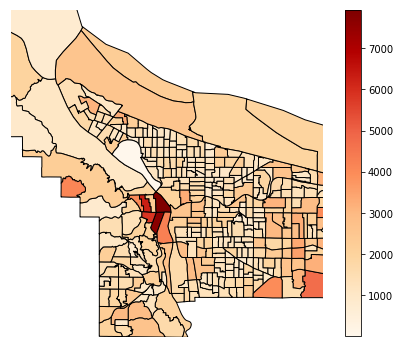

In [51]:
# Maps of total population from census block estimate
# and permanent residents from dogami estimate, both mapped to
# the dogami neighborhood units
# Merging nu geometry from dogami to nu_populations from census blocks to make sure
# geometry is defined correctly
nu_popgeom = pd.merge(loss_gdf[['nuid', 'county', 'geometry']].copy(), nu_populations, on='nuid', how='inner')

gpa1 = gplt.choropleth(nu_popgeom[nu_popgeom['county']=='Multnomah'], 
                hue=nu_popgeom[nu_popgeom['county']=='Multnomah']['Total_Population'], 
                k=None,
                cmap='OrRd',
                edgecolor='k',
                linewidth=1,
                legend=True,
                #scheme='equal_interval',
                projection=gcrs.AlbersEqualArea()
                #figsize=(10, 10)
)
gpa1_xlim = gpa1.get_xlim()
gpa1_ylim = gpa1.get_ylim()
#print(gpa_xlim, gpa_ylim)
delx = 7000
dely = 7000
gpa1.set_xlim([gpa1_xlim[0]+delx, gpa1_xlim[1]-7.5*delx])
gpa1.set_ylim([gpa1_ylim[0], gpa1_ylim[1]-dely])
plt.savefig("DogN_TotalPopulation_CB.png")

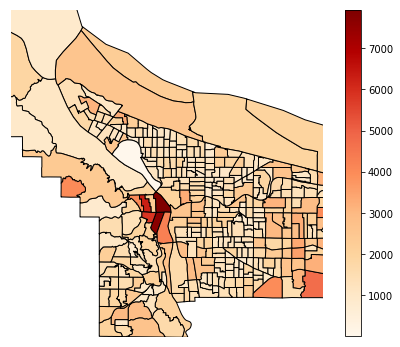

In [50]:
gpa2 = gplt.choropleth(loss_gdf[loss_gdf['county']=='Multnomah'], 
                hue=loss_gdf[loss_gdf['county']=='Multnomah']['permanentresidents'],
                k=None,
                cmap='OrRd',
                edgecolor='k',
                linewidth=1,
                legend=True,
                #scheme='equal_interval',,
                projection=gcrs.AlbersEqualArea()
                #figsize=(10, 10)
) 
gpa2_xlim = gpa2.get_xlim()
gpa2_ylim = gpa2.get_ylim()
#print(gpa_xlim, gpa_ylim)
delx = 7000
dely = 7000
gpa2.set_xlim([gpa2_xlim[0]+delx, gpa2_xlim[1]-7.5*delx])
gpa2.set_ylim([gpa2_ylim[0], gpa2_ylim[1]-dely])
plt.savefig("DogN_PermanentResidents_NU.png")

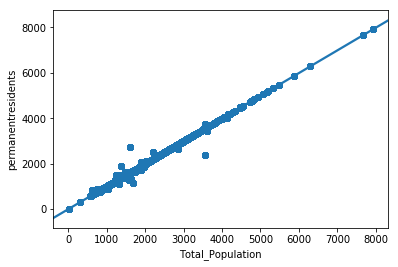

In [52]:
# Plot comparing population estimates from dogami (permanentresidents) and 
# census block (Total_Population), Note this is for all neighborhood units
# in the tricounties area
sns.regplot(x=block_loss['Total_Population'], y=block_loss['permanentresidents'])
plt.savefig("TotalPopulation_vs_PermanentResidents.png")

We can then take any NU unit value that can be summed and then calculate its population weighted value for a census block. We can then calculate the centroid of each block and do a spatial join of those centroids to the Disaster Team Neighborhoods (DN) to determine which DN to allocate those values to.

In [23]:
block_loss.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 35309 entries, 0 to 35308
Data columns (total 67 columns):
STATEFP10                        35309 non-null object
COUNTYFP10                       35309 non-null object
TRACTCE10                        35309 non-null object
BLOCKCE                          35309 non-null object
BLOCKID10                        35309 non-null object
PARTFLG                          35309 non-null object
HOUSING10                        35309 non-null int64
POP10                            35309 non-null int64
geometry                         35309 non-null object
block_center_gpd                 35309 non-null object
index_right                      35309 non-null int64
nuid                             35309 non-null int64
county                           35309 non-null object
acres                            35309 non-null float64
buildingcount                    35309 non-null int64
buildingsquarefeet               35309 non-null int64
building

In [24]:
block_loss.crs

{'init': 'epsg:4326'}

In [25]:
# Step 2) Load the neighborhood geometry shapefile
disneigh_gdf = get_geodf_geometry(**params['geometry_out'])
# Remove columns that aren't required
disneigh_gdf = disneigh_gdf.drop(columns=['fid_1', 'area', 'sqmile', 'Area_Recal', 'Perim', 'Isop'])

In [26]:
# Step 3) Spatial join disaster neighborhoods with centroids of census block loss data
block_loss = block_loss.set_geometry('block_center_gpd')

In [27]:
print(block_loss.geometry.head())

0    POINT (-122.7696838862927 45.32483559506996)
1    POINT (-122.8446243981086 45.33939934620666)
2    POINT (-122.7816293869913 45.32115602984181)
3     POINT (-122.770159928264 45.31773526615596)
4    POINT (-122.7705483969993 45.31430123138469)
Name: block_center_gpd, dtype: object


In [28]:
# Perform spatial join to assign disaster neighborhood (DN) to each census block,
# based on which DN the centroid of the census block falls within

# drop index created from previous spatial join
# see https://gis.stackexchange.com/questions/265864/multiple-spatial-joins-with-geopandas-in-python

#block_loss.drop('index_left', axis=1, inplace=True)
block_loss.drop('index_right', axis=1, inplace=True)

# now spatial join
final = gpd.sjoin(block_loss, disneigh_gdf, how='inner', op='intersects')
final.info()
#print(final.name.sort_values())

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 14357 entries, 606 to 26396
Data columns (total 68 columns):
STATEFP10                        14357 non-null object
COUNTYFP10                       14357 non-null object
TRACTCE10                        14357 non-null object
BLOCKCE                          14357 non-null object
BLOCKID10                        14357 non-null object
PARTFLG                          14357 non-null object
HOUSING10                        14357 non-null int64
POP10                            14357 non-null int64
geometry                         14357 non-null object
block_center_gpd                 14357 non-null object
nuid                             14357 non-null int64
county                           14357 non-null object
acres                            14357 non-null float64
buildingcount                    14357 non-null int64
buildingsquarefeet               14357 non-null int64
buildingcost                     14357 non-null float64
buil

In [29]:
final.tail()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE,BLOCKID10,PARTFLG,HOUSING10,POP10,geometry,block_center_gpd,...,fatalitiestotal_night_dry,injuriestotal_day_wet,injuriestotal_night_wet,injuriestotal_day_dry,injuriestotal_night_dry,Total_Population,Total_Housing_Units,pop_weight,index_right,name
26388,41,051,009301,2002,410510093012002,N,65,146,"POLYGON ((-122.49771 45.525561, -122.497717 45...",POINT (-122.4981275598921 45.52571227619552),...,0.023111,1.983918,2.173222,1.983918,2.173222,3990,1542,0.036591,31,GLENFAIR
26393,41,051,009301,3006,410510093013006,N,11,33,"POLYGON ((-122.501594 45.521414, -122.501618 4...",POINT (-122.5021043048276 45.52083354263563),...,0.023111,1.983918,2.173222,1.983918,2.173222,3990,1542,0.008271,31,GLENFAIR
26394,41,051,009301,2007,410510093012007,N,15,39,"POLYGON ((-122.509344 45.524438, -122.509223 4...",POINT (-122.5086361608108 45.52542733374595),...,0.023111,1.983918,2.173222,1.983918,2.173222,3990,1542,0.009774,31,GLENFAIR
26395,41,051,009301,3004,410510093013004,N,0,0,"POLYGON ((-122.501577 45.522296, -122.500888 4...",POINT (-122.5014075950998 45.52222203029233),...,0.023111,1.983918,2.173222,1.983918,2.173222,3990,1542,0.000000,31,GLENFAIR
26396,41,051,009301,2008,410510093012008,N,48,141,"POLYGON ((-122.510611 45.525456, -122.510587 4...",POINT (-122.5095529357789 45.52407893534571),...,0.023111,1.983918,2.173222,1.983918,2.173222,3990,1542,0.035338,31,GLENFAIR


In [30]:
final[final.columns[12:-4]].info()#.multiply(final['pop_weight'], axis="index").head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14357 entries, 606 to 26396
Data columns (total 52 columns):
acres                            14357 non-null float64
buildingcount                    14357 non-null int64
buildingsquarefeet               14357 non-null int64
buildingcost                     14357 non-null float64
buildingweight                   14357 non-null int64
contentcost                      14357 non-null float64
permanentresidents               14357 non-null int64
dayoccupants                     14357 non-null int64
nightoccupants                   14357 non-null int64
buildingloss_wet                 14357 non-null float64
contentloss_wet                  14357 non-null int64
debris_wet                       14357 non-null int64
displacedpopulation_wet          14357 non-null float64
buildings_nodamage_wet           14357 non-null int64
buildings_slightdamage_wet       14357 non-null int64
buildings_moderatedamage_wet     14357 non-null int64
buildings_exten

In [31]:
nu_loss_final = final[final.columns[12:-4]].multiply(final['pop_weight'], axis="index")

In [32]:
nu_loss_final.head()

,acres,buildingcount,buildingsquarefeet,buildingcost,buildingweight,contentcost,permanentresidents,dayoccupants,nightoccupants,buildingloss_wet,...,casualtiestotal_night_dry,casualtieslevel1_night_dry,casualtieslevel2_night_dry,casualtieslevel3_night_dry,fatalitiestotal_night_dry,injuriestotal_day_wet,injuriestotal_night_wet,injuriestotal_day_dry,injuriestotal_night_dry,Total_Population
606,0.322799,0.909707,2516.916479,2.818555e+05,125.426637,2.569120e+05,2.0,2.618510,2.029345,35833.182844,...,0.003441,0.002844,0.000508,0.000032,0.000056,0.032984,0.003849,0.028450,0.003384,2.0
611,1.452596,4.093679,11326.124153,1.268350e+06,564.419865,1.156104e+06,9.0,11.783296,9.132054,161249.322799,...,0.015483,0.012796,0.002287,0.000146,0.000254,0.148427,0.017322,0.128025,0.015229,9.0
616,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
617,1.291196,3.638826,10067.665914,1.127422e+06,501.706546,1.027648e+06,8.0,10.474041,8.117381,143332.731377,...,0.013763,0.011375,0.002033,0.000130,0.000226,0.131935,0.015398,0.113800,0.013537,8.0
620,7.747178,21.832957,60405.995485,6.764533e+06,3010.239278,6.165887e+06,48.0,62.844244,48.704289,859996.388262,...,0.082577,0.068248,0.012197,0.000778,0.001354,0.791610,0.092385,0.682802,0.081223,48.0


In [33]:
nu_loss_final = pd.concat([final[['name']], nu_loss_final], axis=1)

In [34]:
nu_loss_final.head(5)

,name,acres,buildingcount,buildingsquarefeet,buildingcost,buildingweight,contentcost,permanentresidents,dayoccupants,nightoccupants,...,casualtiestotal_night_dry,casualtieslevel1_night_dry,casualtieslevel2_night_dry,casualtieslevel3_night_dry,fatalitiestotal_night_dry,injuriestotal_day_wet,injuriestotal_night_wet,injuriestotal_day_dry,injuriestotal_night_dry,Total_Population
606,BRENTWOOD/ DARLINGTON,0.322799,0.909707,2516.916479,2.818555e+05,125.426637,2.569120e+05,2.0,2.618510,2.029345,...,0.003441,0.002844,0.000508,0.000032,0.000056,0.032984,0.003849,0.028450,0.003384,2.0
611,BRENTWOOD/ DARLINGTON,1.452596,4.093679,11326.124153,1.268350e+06,564.419865,1.156104e+06,9.0,11.783296,9.132054,...,0.015483,0.012796,0.002287,0.000146,0.000254,0.148427,0.017322,0.128025,0.015229,9.0
616,BRENTWOOD/ DARLINGTON,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
617,BRENTWOOD/ DARLINGTON,1.291196,3.638826,10067.665914,1.127422e+06,501.706546,1.027648e+06,8.0,10.474041,8.117381,...,0.013763,0.011375,0.002033,0.000130,0.000226,0.131935,0.015398,0.113800,0.013537,8.0
620,BRENTWOOD/ DARLINGTON,7.747178,21.832957,60405.995485,6.764533e+06,3010.239278,6.165887e+06,48.0,62.844244,48.704289,...,0.082577,0.068248,0.012197,0.000778,0.001354,0.791610,0.092385,0.682802,0.081223,48.0


In [35]:
# sum each column by neighborhood

rollup = nu_loss_final.groupby('name').sum().reset_index()

In [36]:
rollup.head(25)

,name,acres,buildingcount,buildingsquarefeet,buildingcost,buildingweight,contentcost,permanentresidents,dayoccupants,nightoccupants,...,casualtiestotal_night_dry,casualtieslevel1_night_dry,casualtieslevel2_night_dry,casualtieslevel3_night_dry,fatalitiestotal_night_dry,injuriestotal_day_wet,injuriestotal_night_wet,injuriestotal_day_dry,injuriestotal_night_dry,Total_Population
0,ALAMEDA,395.233795,2252.862663,4.813194e+06,5.830427e+08,1.680060e+05,3.092366e+08,5214.000000,2838.063986,4964.732236,...,3.307856,2.885870,0.361312,0.021074,0.039601,27.343894,14.832849,16.897119,3.268256,5214.0
1,ARBOR LODGE,535.933104,3056.956847,4.598939e+06,5.582640e+08,1.817029e+05,3.278168e+08,6153.000000,3065.604379,5875.075413,...,5.627651,4.703174,0.728863,0.066854,0.128765,11.390552,16.045481,6.427364,5.498891,6153.0
2,ARDENWALD-JOHNSON CREEK,93.953696,217.942020,4.939107e+05,6.413087e+07,1.977144e+04,4.722220e+07,490.000000,289.258328,475.650741,...,0.590858,0.483601,0.084702,0.007793,0.014762,3.255084,2.391730,2.112167,0.576096,490.0
3,ARGAY,786.567762,1723.479466,5.228018e+06,6.908923e+08,2.237542e+05,4.266170e+08,6006.000000,3417.995893,5865.167351,...,17.290831,13.390749,2.925818,0.332734,0.641524,52.905485,28.186179,35.961977,16.649300,6006.0
4,ARLINGTON HEIGHTS,385.517113,315.364583,1.173879e+06,1.805823e+08,6.081581e+04,1.139824e+08,865.000000,862.425595,827.671131,...,14.847815,10.681978,2.957347,0.408713,0.799790,40.488610,25.655308,30.274537,14.048038,865.0
5,ARNOLD CREEK,958.444687,1393.861340,3.782992e+06,4.967833e+08,1.365132e+05,2.647156e+08,3339.000000,2146.020974,3183.172405,...,3.663411,3.032706,0.515793,0.040119,0.074794,23.979223,23.855678,10.976491,3.588617,3339.0
6,ASHCREEK,817.243853,2282.528236,4.816574e+06,5.981949e+08,1.670738e+05,3.121010e+08,5440.000000,2151.358022,5177.787082,...,5.967649,4.933765,0.820356,0.073221,0.140311,17.843393,29.353443,7.512184,5.827343,5440.0
7,BEAUMONT-WILSHIRE,454.325481,2682.727358,4.534219e+06,5.499622e+08,1.705047e+05,2.994011e+08,5185.000000,2627.054422,4934.789655,...,2.675073,2.347863,0.280683,0.016170,0.030357,6.030711,4.029513,5.418065,2.644716,5185.0
8,BOISE,255.554724,1105.822030,3.747091e+06,5.749755e+08,2.388737e+05,4.348476e+08,3298.000000,3528.355589,3324.194687,...,6.602784,5.074927,1.092147,0.146859,0.288856,60.697239,19.239785,44.479903,6.313933,3298.0
9,BRENTWOOD/ DARLINGTON,1147.991071,5301.823078,7.833957e+06,9.487324e+08,3.045010e+05,5.931123e+08,12957.000000,7509.629766,12378.536096,...,7.910606,6.847422,0.936974,0.046245,0.079961,31.877454,9.810244,29.366952,7.830640,12957.0


In [37]:
# Here do we want to divide by Total_Population (from Census Blocks) or divide by permanentresidents?
# I think we want the second one because that way both the numerator and denomenator come from the dogami
# data that we have mapped from neighborhood unit to disaster neighborhood
#rollup['displaced_percap_wet'] = rollup['displacedpopulation_wet']/rollup['Total_Population']
rollup['displaced_percap_wet'] = rollup['displacedpopulation_wet'] / rollup['permanentresidents']
rollup['displaced_percap_dry'] = rollup['displacedpopulation_dry'] / rollup['permanentresidents']

In [38]:
# export to csv
rollup.to_csv("Data/neighborhood_loss_final.csv")

(45.4, 45.7)

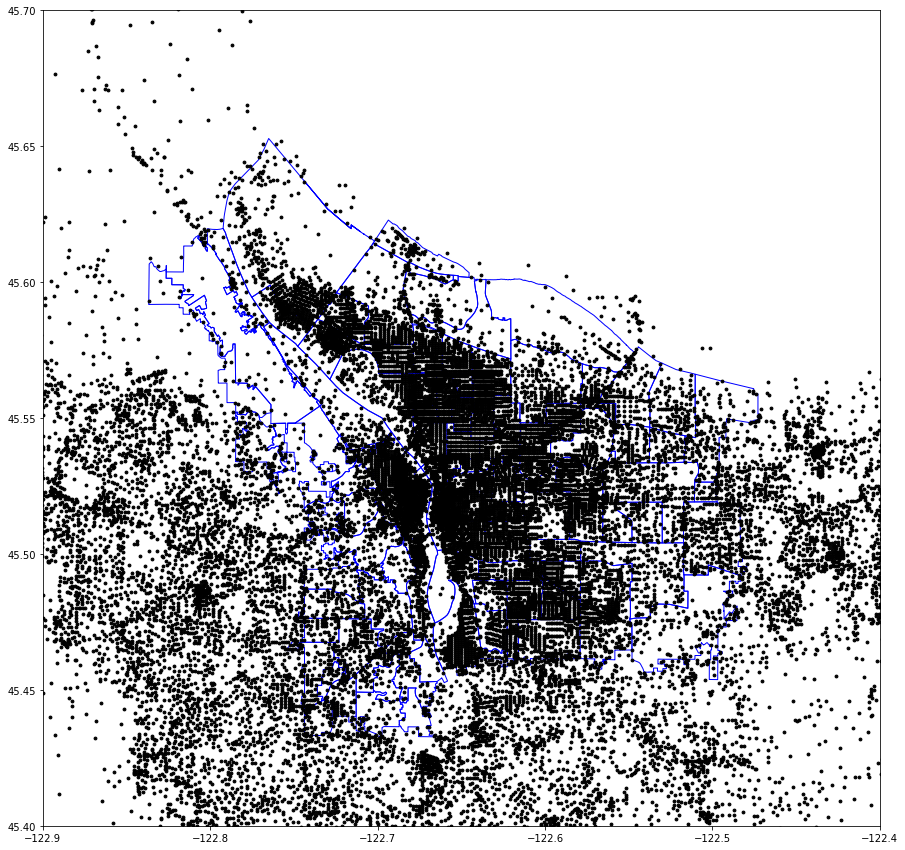

In [60]:
# overlay census blocks on disaster neighborhoods

fig, ax = plt.subplots(1, figsize=(15, 15))
disneigh_gdf.plot(ax=ax, edgecolor='b', linewidth=1, facecolor="None")
block_loss.plot(ax=ax, color='k', markersize=8)
ax.set_xlim([-122.9, -122.4])
ax.set_ylim([45.4, 45.7])

In [40]:
# some summary stats
rollup.describe()

,acres,buildingcount,buildingsquarefeet,buildingcost,buildingweight,contentcost,permanentresidents,dayoccupants,nightoccupants,buildingloss_wet,...,casualtieslevel2_night_dry,casualtieslevel3_night_dry,fatalitiestotal_night_dry,injuriestotal_day_wet,injuriestotal_night_wet,injuriestotal_day_dry,injuriestotal_night_dry,Total_Population,displaced_percap_wet,displaced_percap_dry
count,101.000000,101.000000,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,101.000000,101.000000,101.000000,1.010000e+02,...,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,958.387268,2046.185563,6.620132e+06,9.462646e+08,3.679190e+05,7.301708e+08,5782.672967,6683.523150,6042.304501,1.855935e+08,...,4.667615,0.602598,1.177624,143.602750,46.734878,101.892154,24.673623,5783.079208,0.080377,0.020428
std,1016.194169,1709.752887,6.102601e+06,9.942398e+08,4.790243e+05,8.971419e+08,5002.101729,7768.167444,5102.026626,3.309309e+08,...,11.201949,1.508887,2.964708,251.912264,79.459349,186.178721,55.728457,4999.830148,0.087510,0.037198
min,0.954589,0.716908,2.564579e+03,3.943324e+05,1.228918e+02,3.139556e+05,2.000000,5.231884,1.950725,6.337585e+04,...,0.000742,0.000078,0.000150,0.103845,0.014927,0.074034,0.004394,2.000000,0.000655,0.000655
25%,381.694636,742.215158,3.661483e+06,4.602325e+08,1.582140e+05,2.994011e+08,2198.000000,2513.571209,2547.972451,3.134396e+07,...,0.455230,0.039541,0.074881,16.859000,11.185822,10.891285,3.730715,2198.000000,0.018797,0.002712
50%,549.817368,1783.351108,4.984763e+06,6.503502e+08,2.311197e+05,4.480667e+08,5185.000000,4452.129715,5146.083011,6.580488e+07,...,1.346407,0.121295,0.215307,44.334015,23.855678,31.481457,8.496645,5214.000000,0.056580,0.006280
75%,1024.950776,2857.627232,8.623210e+06,1.207153e+09,4.941157e+05,9.604240e+08,7335.000000,9099.934209,7937.706215,1.953147e+08,...,3.873579,0.507499,0.996865,149.997337,49.280668,101.182996,20.573239,7335.000000,0.083677,0.014686
max,5719.125242,7300.079504,4.703497e+07,8.221520e+09,4.113409e+06,7.201128e+09,25112.731260,61896.919509,24036.248903,2.515984e+09,...,98.445678,12.768180,25.060819,1814.406692,658.012606,1424.874434,496.623608,25113.000000,0.362291,0.168945


In [41]:
# city level sums
pd.set_option('display.max_rows', 100) # increase display option to show more rows
rollup.sum()

name                             ALAMEDAARBOR LODGEARDENWALD-JOHNSON CREEKARGAY...
acres                                                                      96797.1
buildingcount                                                               206665
buildingsquarefeet                                                     6.68633e+08
buildingcost                                                           9.55727e+10
buildingweight                                                         3.71598e+07
contentcost                                                            7.37472e+10
permanentresidents                                                          584050
dayoccupants                                                                675036
nightoccupants                                                              610273
buildingloss_wet                                                       1.87449e+10
contentloss_wet                                                        7.78761e+09
debr

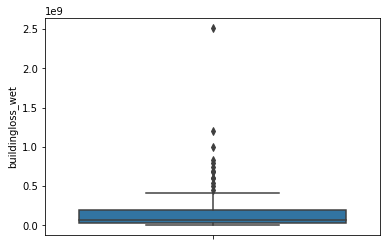

In [64]:
#boxplot of damage by neighborhood

sns.boxplot(y=rollup['buildingloss_wet'])

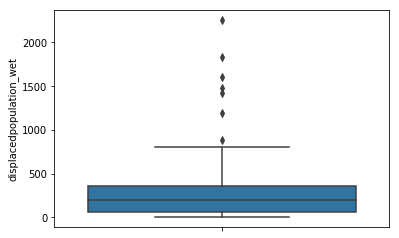

In [65]:
## boxplot of dsiplaced population by neighborhood
sns.boxplot(y=rollup['displacedpopulation_wet'])

In [42]:
# merge neighborhood shapes back onto rollup
rollup = disneigh_gdf.merge(rollup, on='name', how='inner')

In [43]:
rollup.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 56 columns):
name                             101 non-null object
geometry                         101 non-null object
acres                            101 non-null float64
buildingcount                    101 non-null float64
buildingsquarefeet               101 non-null float64
buildingcost                     101 non-null float64
buildingweight                   101 non-null float64
contentcost                      101 non-null float64
permanentresidents               101 non-null float64
dayoccupants                     101 non-null float64
nightoccupants                   101 non-null float64
buildingloss_wet                 101 non-null float64
contentloss_wet                  101 non-null float64
debris_wet                       101 non-null float64
displacedpopulation_wet          101 non-null float64
buildings_nodamage_wet           101 non-null float64
buildings_slightdamage_we

In [44]:
# which neighborhood is missing from rollup after spatial join to block data?
# 6/11/18 only 1 neighborhood missing now

disneigh_gdf['name'][~disneigh_gdf['name'].isin(rollup['name'])]

index_right
69    PORTLAND UNCLAIMED #2
Name: name, dtype: object

Ryan checked Portland Unclaimed #2 and found that no blocks intersect this neighborhood it makes sense that it's missing from the joined dataframe.

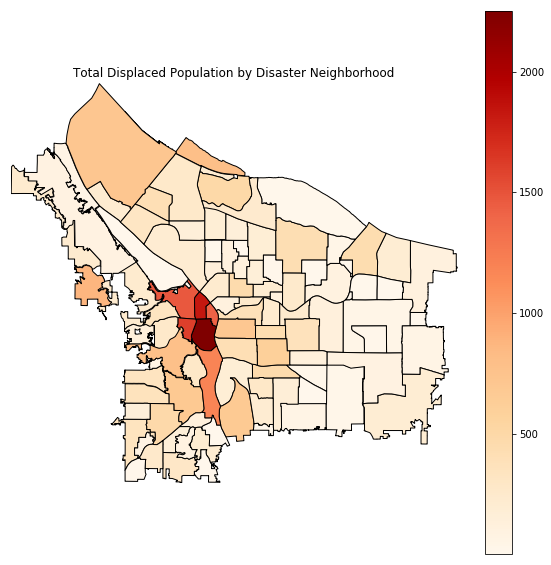

In [48]:
# plot choropleths
gplt.choropleth(rollup,
                hue=rollup['displacedpopulation_wet'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                edgecolor='k',
                linewidth=1,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10)
)
plt.title("Total Displaced Population by Disaster Neighborhood")
plt.savefig("DisN_TotalDisplacedPopulation.png")

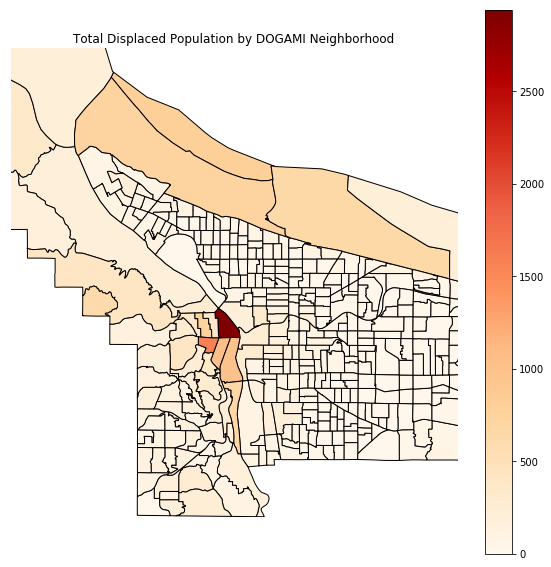

In [49]:
# Dogami neighborhood units in Multnomah county showing displaced population,
# for comparison with displaced population by disaster neighborhood (above)
gpa = gplt.choropleth(loss_gdf[loss_gdf['county']=='Multnomah'],
                hue=loss_gdf[loss_gdf['county']=='Multnomah']['displacedpopulation_wet'],
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                edgecolor='k',
                linewidth=1,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10)
)
gpa_xlim = gpa.get_xlim()
gpa_ylim = gpa.get_ylim()
#print(gpa_xlim, gpa_ylim)
delx = 7000
dely = 7000
gpa.set_xlim([gpa_xlim[0]+delx, gpa_xlim[1]-7.5*delx])
gpa.set_ylim([gpa_ylim[0], gpa_ylim[1]-dely])
plt.title("Total Displaced Population by DOGAMI Neighborhood")
plt.savefig("DogN_TotalDisplacedPopulation.png")

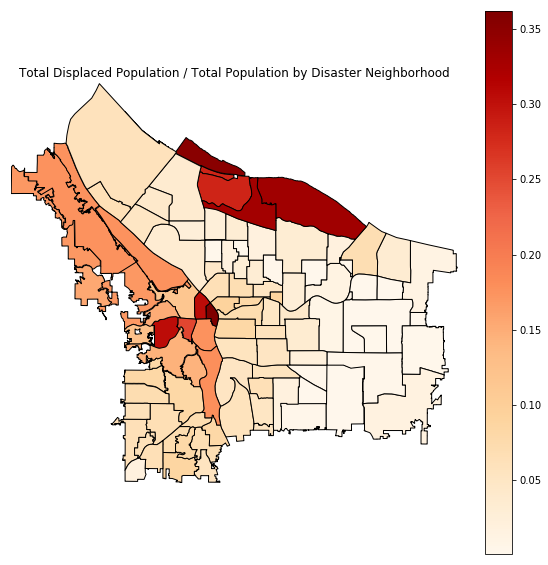

In [53]:
# displacement ratio per neighborhood

gplt.choropleth(rollup,
                hue=rollup['displaced_percap_wet'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                edgecolor='k',
                linewidth=1,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Total Displaced Population / Total Population by Disaster Neighborhood")
plt.savefig("DisN_TotalDisplacedPopulationRatio.png")

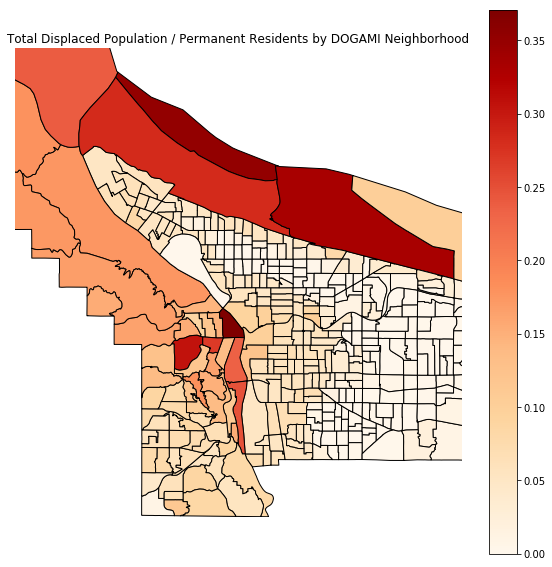

In [54]:
# Dogami neighborhood units in Multnomah county showing displaced population divided
# by permanent residents,
# for comparison with displaced population ratio by disaster neighborhood (above)
gpa = gplt.choropleth(loss_gdf[loss_gdf['county']=='Multnomah'],
                hue=loss_gdf[loss_gdf['county']=='Multnomah']['displacedpopulation_wet']/
                      loss_gdf[loss_gdf['county']=='Multnomah']['permanentresidents'],
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                edgecolor='k',
                linewidth=1,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10)
)
gpa_xlim = gpa.get_xlim()
gpa_ylim = gpa.get_ylim()
#print(gpa_xlim, gpa_ylim)
delx = 7000
dely = 7000
gpa.set_xlim([gpa_xlim[0]+delx, gpa_xlim[1]-7.5*delx])
gpa.set_ylim([gpa_ylim[0], gpa_ylim[1]-dely])
plt.title("Total Displaced Population / Permanent Residents by DOGAMI Neighborhood")
plt.savefig("DogN_TotalDisplacedPopulationRatio.png")

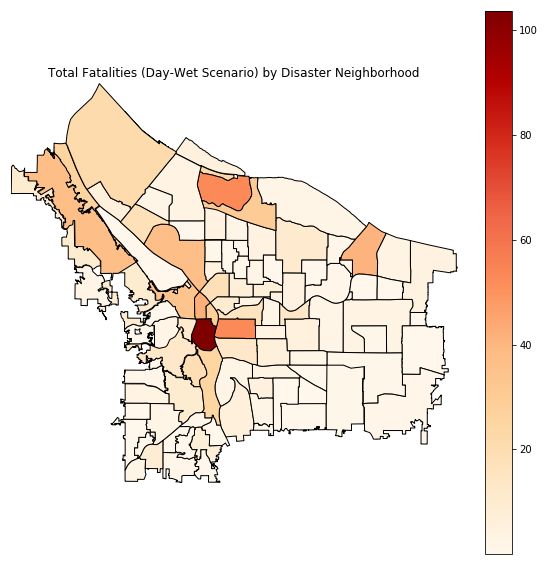

In [55]:
# Disaster neighborhood showing total fatalities in day-wet scenario
gplt.choropleth(rollup,
                hue=rollup['fatalitiestotal_day_wet'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                edgecolor='k',
                linewidth=1,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10)
)
plt.title("Total Fatalities (Day-Wet Scenario) by Disaster Neighborhood")
plt.savefig("DisN_TotalFatalities_DayWet.png")

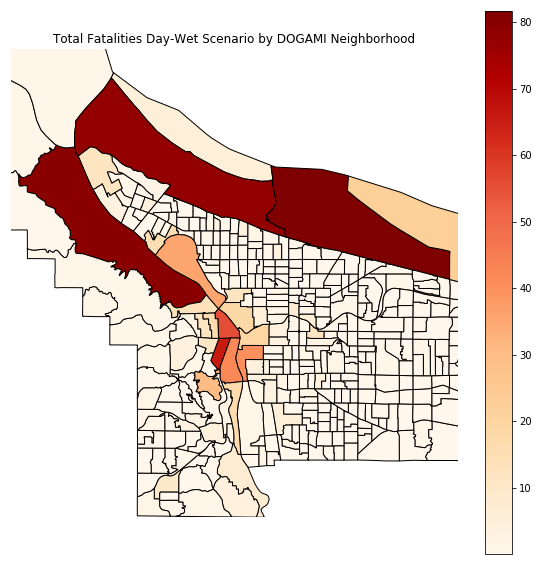

In [58]:
# Dogami neighborhood units in Multnomah county showing total fatalities in day-wet scenario,
# for comparison with fatalities by disaster neighborhood (above)
gpa = gplt.choropleth(loss_gdf[loss_gdf['county']=='Multnomah'],
                hue=loss_gdf[loss_gdf['county']=='Multnomah']['fatalitiestotal_day_wet'],
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                edgecolor='k',
                linewidth=1,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10),
                #vmin=0,
                #vmax=100
)
gpa_xlim = gpa.get_xlim()
gpa_ylim = gpa.get_ylim()
#print(gpa_xlim, gpa_ylim)
delx = 7000
dely = 7000
gpa.set_xlim([gpa_xlim[0]+delx, gpa_xlim[1]-7.5*delx])
gpa.set_ylim([gpa_ylim[0], gpa_ylim[1]-dely])
plt.title("Total Fatalities Day-Wet Scenario by DOGAMI Neighborhood")
plt.savefig("DogN_TotalFatalities_DayWet.png")

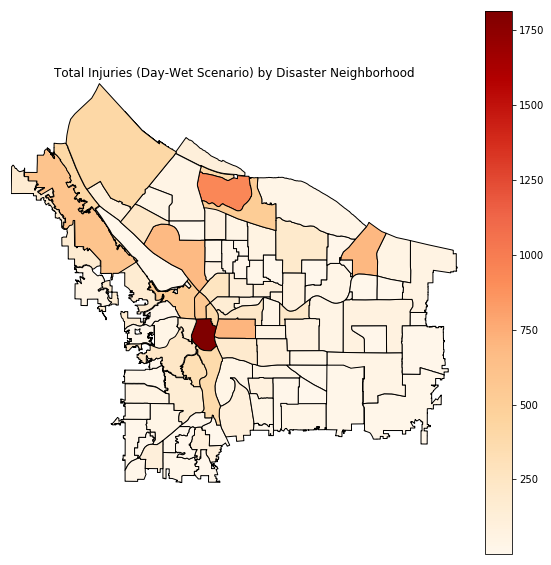

In [62]:
# Disaster neighborhood showing total injuries in day-wet scenario
gplt.choropleth(rollup,
                hue=rollup['injuriestotal_day_wet'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                edgecolor='k',
                linewidth=1,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10)
)
plt.title("Total Injuries (Day-Wet Scenario) by Disaster Neighborhood")
plt.savefig("DisN_TotalInjuries_DayWet.png")

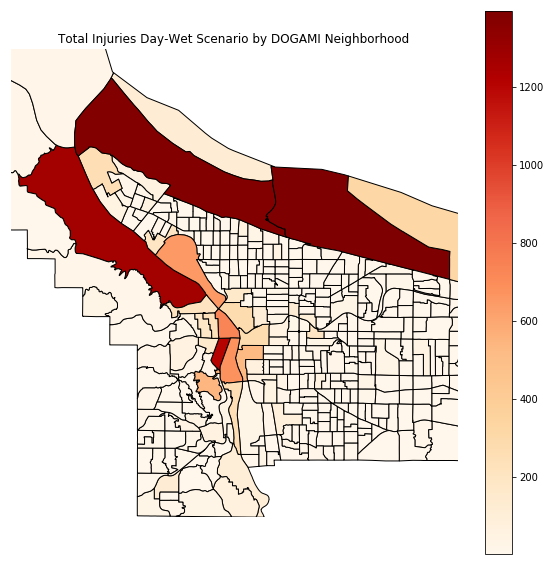

In [63]:
# Dogami neighborhood units in Multnomah county showing total injuries in day-wet scenario,
# for comparison with injuries by disaster neighborhood (above)
gpa = gplt.choropleth(loss_gdf[loss_gdf['county']=='Multnomah'],
                hue=loss_gdf[loss_gdf['county']=='Multnomah']['injuriestotal_day_wet'],
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                edgecolor='k',
                linewidth=1,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10),
                #vmin=0,
                #vmax=100
)
gpa_xlim = gpa.get_xlim()
gpa_ylim = gpa.get_ylim()
#print(gpa_xlim, gpa_ylim)
delx = 7000
dely = 7000
gpa.set_xlim([gpa_xlim[0]+delx, gpa_xlim[1]-7.5*delx])
gpa.set_ylim([gpa_ylim[0], gpa_ylim[1]-dely])
plt.title("Total Injuries Day-Wet Scenario by DOGAMI Neighborhood")
plt.savefig("DogN_TotalInjuries_DayWet.png")

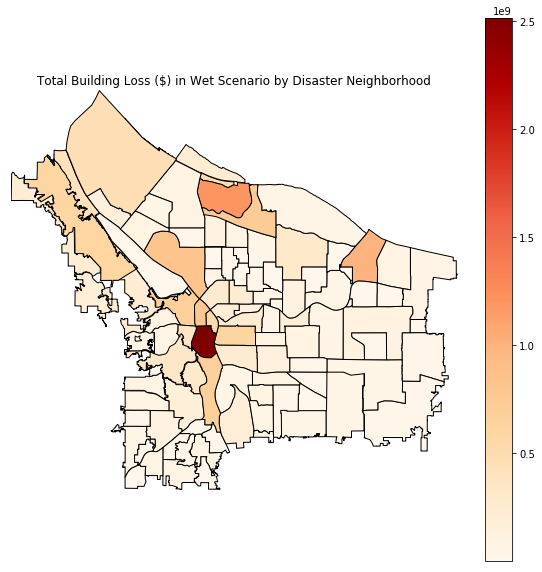

In [59]:
# Disaster neighborhood showing total building loss in wet scenario
gplt.choropleth(rollup,
                hue=rollup['buildingloss_wet'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                edgecolor='k',
                linewidth=1,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10)
)
plt.title("Total Building Loss ($) in Wet Scenario by Disaster Neighborhood")
plt.savefig("DisN_TotalBuildingLoss_Wet.png")

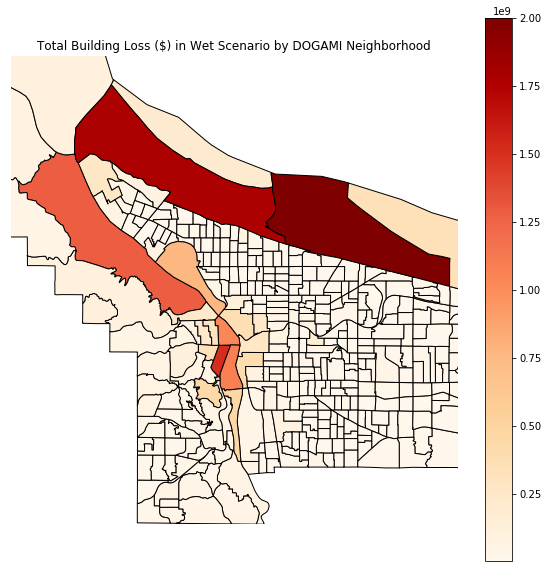

In [60]:
# Dogami neighborhood units in Multnomah county showing total fatalities in day-wet scenario,
# for comparison with casualties by disaster neighborhood (above)
gpa = gplt.choropleth(loss_gdf[loss_gdf['county']=='Multnomah'],
                hue=loss_gdf[loss_gdf['county']=='Multnomah']['buildingloss_wet'],
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                edgecolor='k',
                linewidth=1,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10),
                #vmin=0,
                #vmax=100
)
gpa_xlim = gpa.get_xlim()
gpa_ylim = gpa.get_ylim()
#print(gpa_xlim, gpa_ylim)
delx = 7000
dely = 7000
gpa.set_xlim([gpa_xlim[0]+delx, gpa_xlim[1]-7.5*delx])
gpa.set_ylim([gpa_ylim[0], gpa_ylim[1]-dely])
plt.title("Total Building Loss ($) in Wet Scenario by DOGAMI Neighborhood")
plt.savefig("DogN_TotalBuildingLoss_Wet.png")

## Comparisons of Neighborhood Loss to Census Response Rate

In [ ]:
# load census response rate by neighborhood
crr = pd.read_csv("./Data/neighborhood_census_response_rate.csv")

In [ ]:
crr.head()

In [ ]:
# scatterplot of crr vs total displaced wet

sns.lmplot(data=rollup.merge(crr, on='name', how='inner'),
           x='census_response_rate', 
           y='displacedpopulation_wet',
          fit_reg=False)

In [ ]:
# scatterplot of crr vs displaced ratio wet

sns.lmplot(data=rollup.merge(crr, on='name', how='inner'),
           x='census_response_rate', 
           y='displaced_percap_wet',
          fit_reg=False)

In [ ]:
# scatterplot of crr vs total day casualties wet

sns.lmplot(data=rollup.merge(crr, on='name', how='inner'),
           x='census_response_rate', 
           y='casualtiestotal_day_wet',
          fit_reg=False)

In [ ]:
# scatterplot of crr vs building loss wet

sns.lmplot(data=rollup.merge(crr, on='name', how='inner'),
           x='census_response_rate', 
           y='buildingloss_wet',
          fit_reg=False)